## Yield curve prediction

The goal of this study is to predict the yield curve.


# Problem Definition

In the supervised regression framework used for this case study, three tenors (i.e. 1M,
5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short
term, medium term and long-term tenors of the yield curve.



In [2]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from scikeras.wrappers import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


## Loading the Data

In [4]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [5]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [6]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2021-01-01,0.08,0.49,1.87,0.08,0.09,0.10,0.13,0.36,0.65,0.93,1.65,0.166672,0.782256,0.250183,2.18
2021-01-08,0.08,0.46,1.85,0.08,0.08,0.10,0.14,0.49,0.81,1.13,1.87,0.167046,0.782256,0.250183,2.19
2021-01-15,0.07,0.42,1.80,0.08,0.09,0.10,0.13,0.46,0.78,1.11,1.85,0.167910,0.782256,0.250183,2.13
2021-01-25,0.06,0.42,1.84,0.07,0.09,0.10,0.13,0.42,0.73,1.05,1.80,0.168614,0.782256,0.250183,2.15
2021-02-01,0.04,0.48,1.96,0.06,0.07,0.08,0.11,0.42,0.76,1.09,1.84,0.169416,0.782256,0.250183,2.19


In [7]:
dataset

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2021-01-01,0.08,0.49,1.87,0.08,0.09,0.10,0.13,0.36,0.65,0.93,1.65,0.166672,0.782256,0.250183,2.18
2021-01-08,0.08,0.46,1.85,0.08,0.08,0.10,0.14,0.49,0.81,1.13,1.87,0.167046,0.782256,0.250183,2.19
2021-01-15,0.07,0.42,1.80,0.08,0.09,0.10,0.13,0.46,0.78,1.11,1.85,0.167910,0.782256,0.250183,2.13
2021-01-25,0.06,0.42,1.84,0.07,0.09,0.10,0.13,0.42,0.73,1.05,1.80,0.168614,0.782256,0.250183,2.15
2021-02-01,0.04,0.48,1.96,0.06,0.07,0.08,0.11,0.42,0.76,1.09,1.84,0.169416,0.782256,0.250183,2.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-20,4.09,3.61,4.57,4.15,3.97,3.55,3.46,3.58,3.77,4.00,4.58,0.115882,0.800193,0.252067,1.68
2025-10-27,4.06,3.72,4.69,4.09,3.89,3.59,3.48,3.61,3.79,4.01,4.57,0.115888,0.800193,0.252067,1.63
2025-11-03,4.04,3.72,4.71,4.06,3.98,3.70,3.60,3.72,3.90,4.13,4.69,0.115895,0.800193,0.252067,1.71



# Exploratory Data Analysis

In [8]:
dataset.shape

(247, 15)

In [10]:
#pd.set_option('precision', 3)
dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,3.284899,3.192470,3.675101,3.268866,3.348097,3.308583,3.193846,3.179555,3.281255,3.352510,3.662874,0.154042,0.790518,0.244495,1.847733
std,2.214849,1.327187,1.046606,2.223676,2.172095,1.935243,1.693420,1.339161,1.229779,1.162148,1.052559,0.028037,0.006835,0.011319,0.252229
min,0.000000,0.420000,1.770000,0.000000,0.010000,0.040000,0.110000,0.360000,0.650000,0.930000,1.650000,0.115785,0.781015,0.226400,1.360000
25%,0.180000,2.550000,2.520000,0.170000,0.475000,1.480000,2.135000,2.345000,2.335000,2.265000,2.430000,0.124031,0.783525,0.234440,1.670000
50%,4.350000,3.790000,3.980000,4.350000,4.340000,4.100000,3.930000,3.790000,3.850000,3.840000,3.980000,0.159649,0.788131,0.242631,1.840000
75%,5.355000,4.130000,4.570000,5.355000,5.340000,4.825000,4.435000,4.130000,4.190000,4.270000,4.560000,0.183174,0.796804,0.252067,2.030000
max,5.950000,4.860000,5.040000,5.950000,5.620000,5.490000,5.190000,4.860000,4.890000,4.880000,5.040000,0.190844,0.800193,0.266310,2.420000



##  Data Visualization

<Axes: xlabel='DATE'>

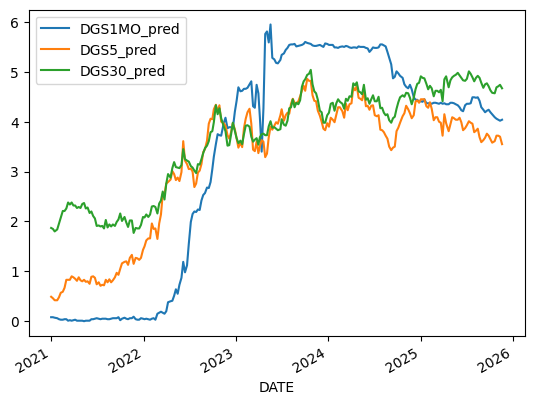

In [11]:
Y.plot()

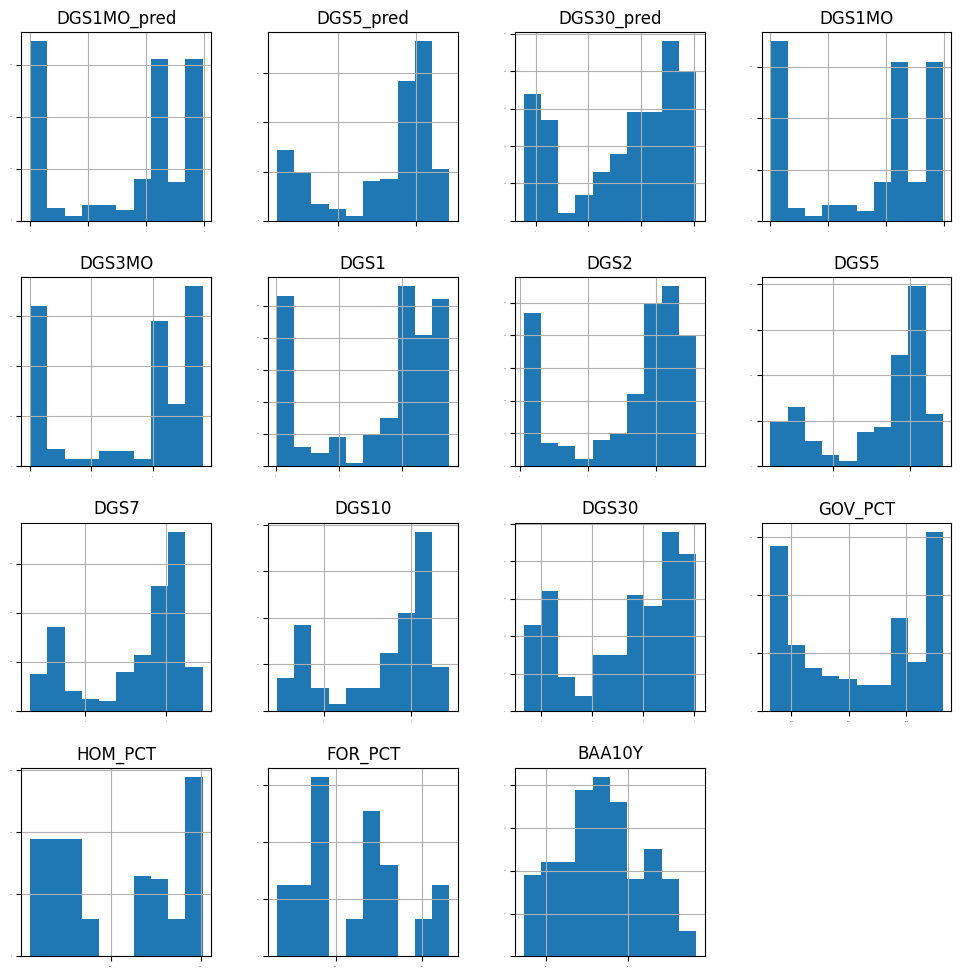

In [12]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

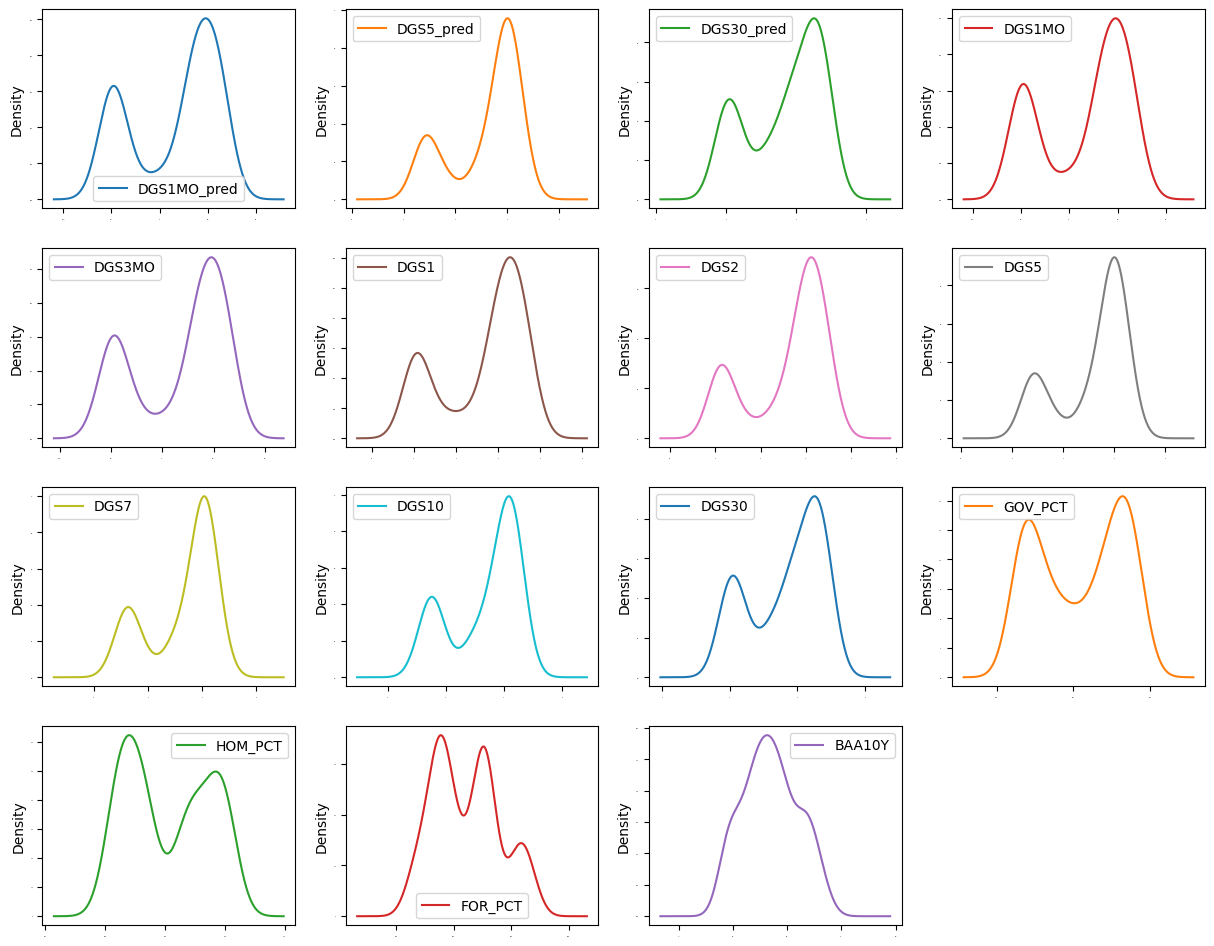

In [13]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

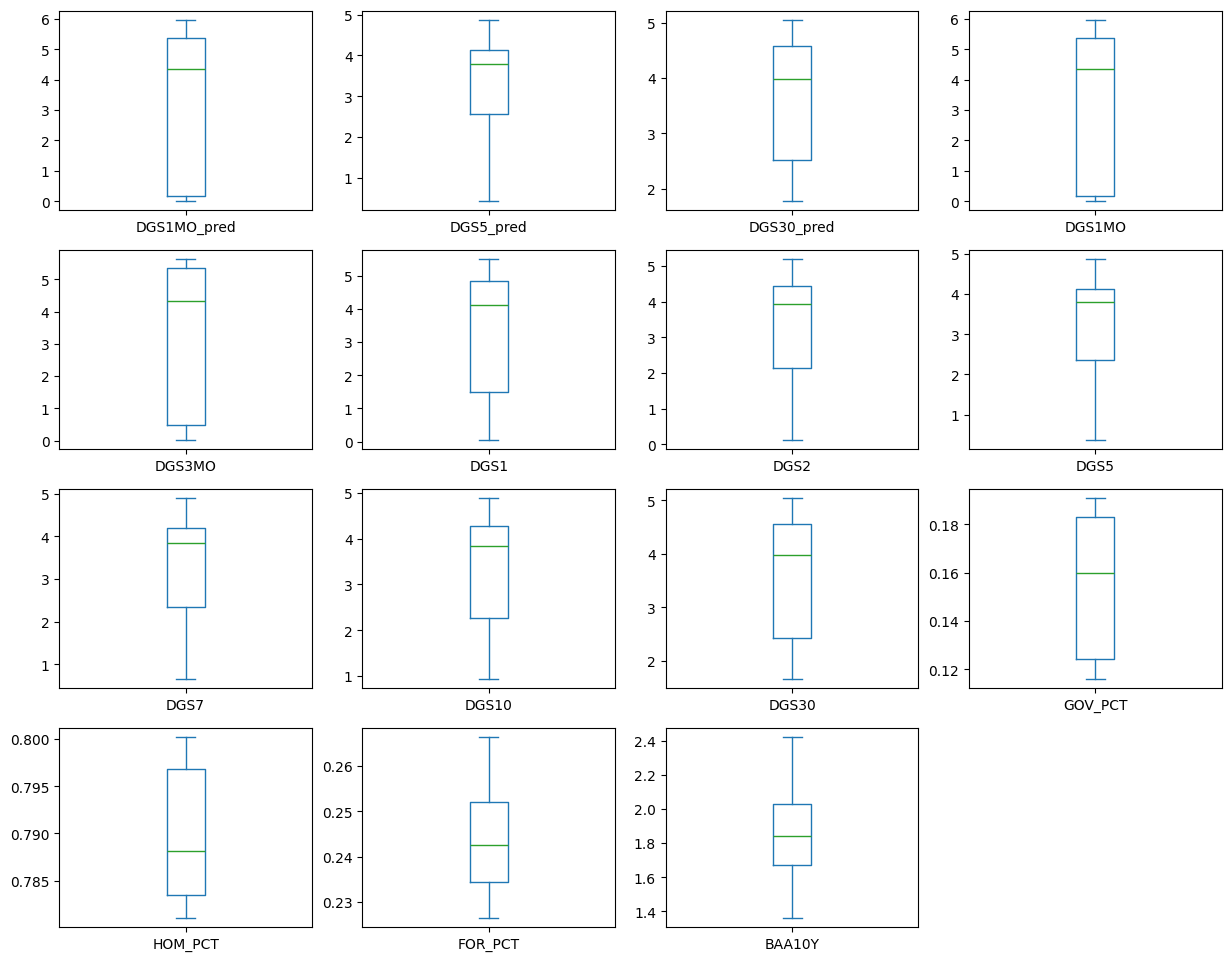

In [14]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

Next We look at the interaction between these variables.

<Axes: title={'center': 'Correlation Matrix'}>

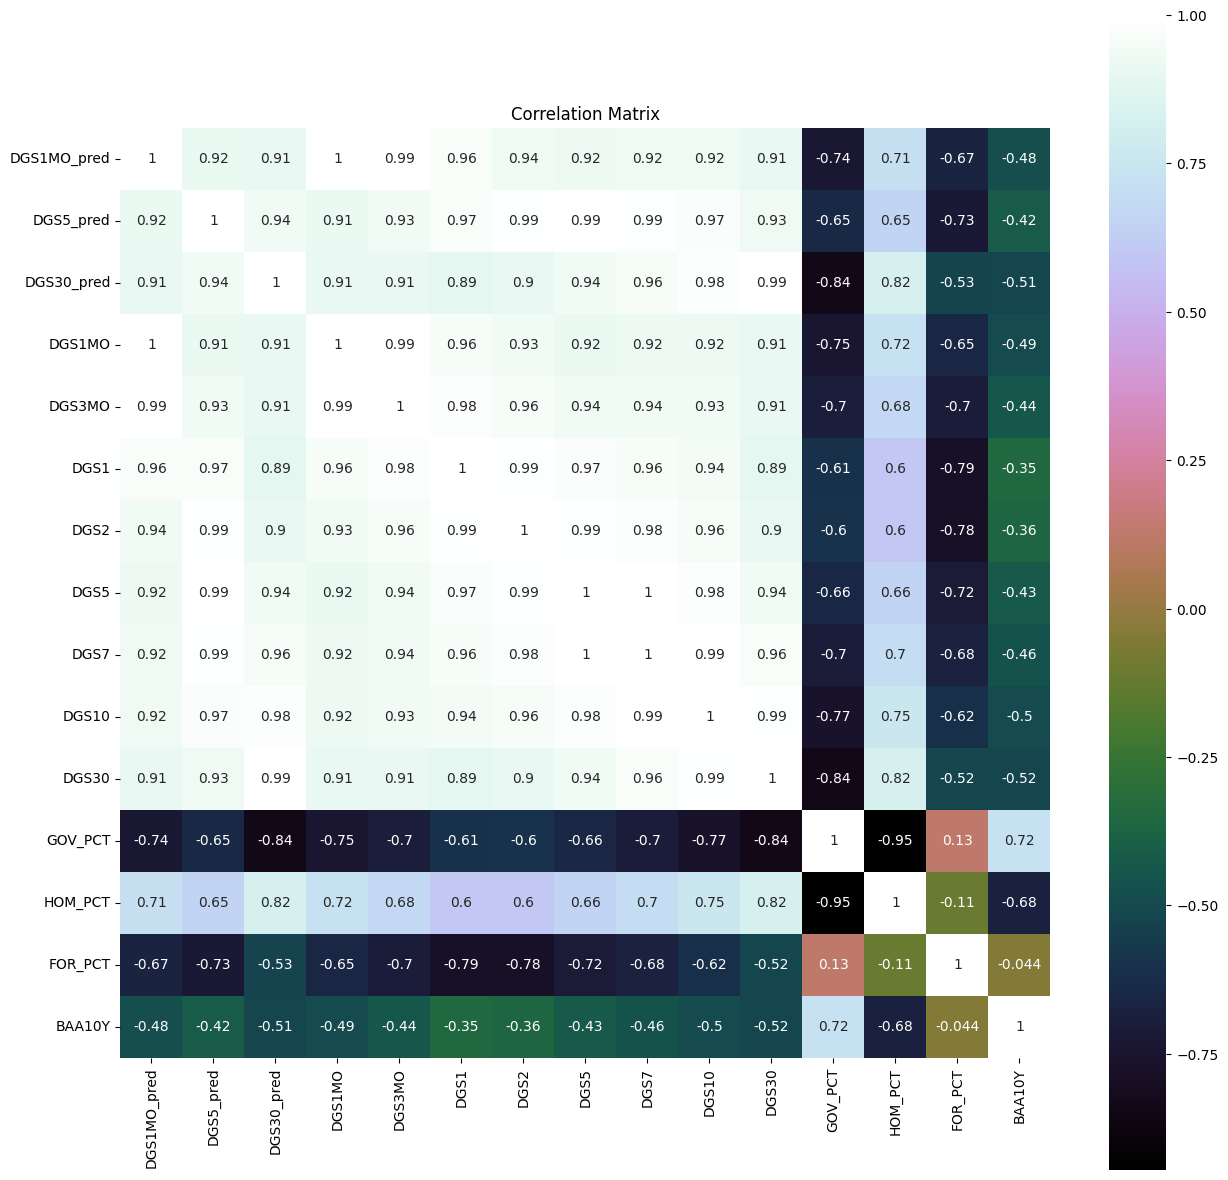

In [15]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1500x1500 with 0 Axes>

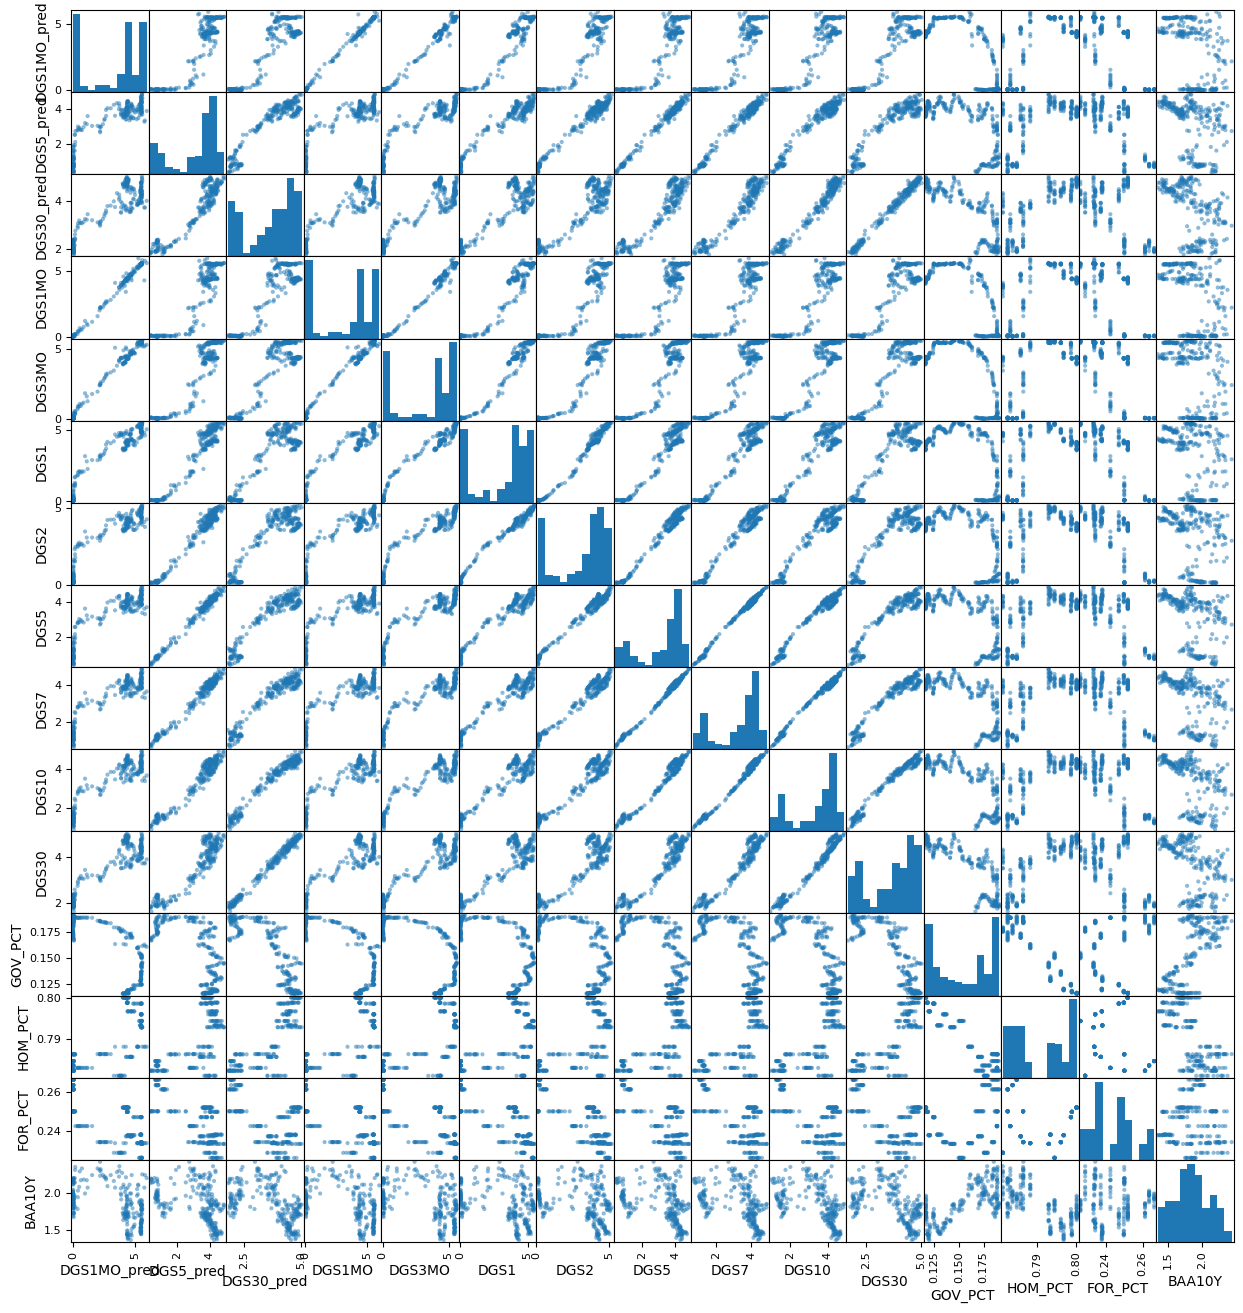

In [16]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()


##  Time Series Analysis

#### 1 Month

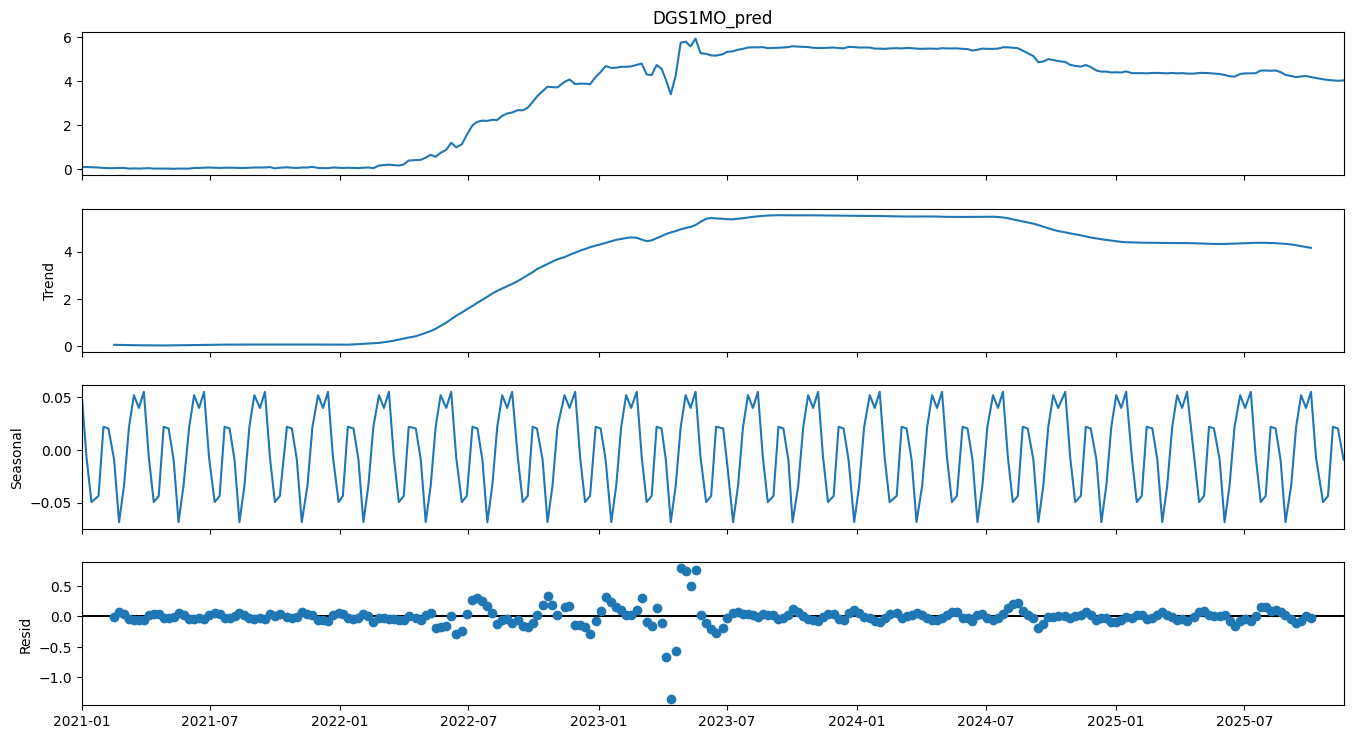

In [19]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y, model='additive', period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 5 Year

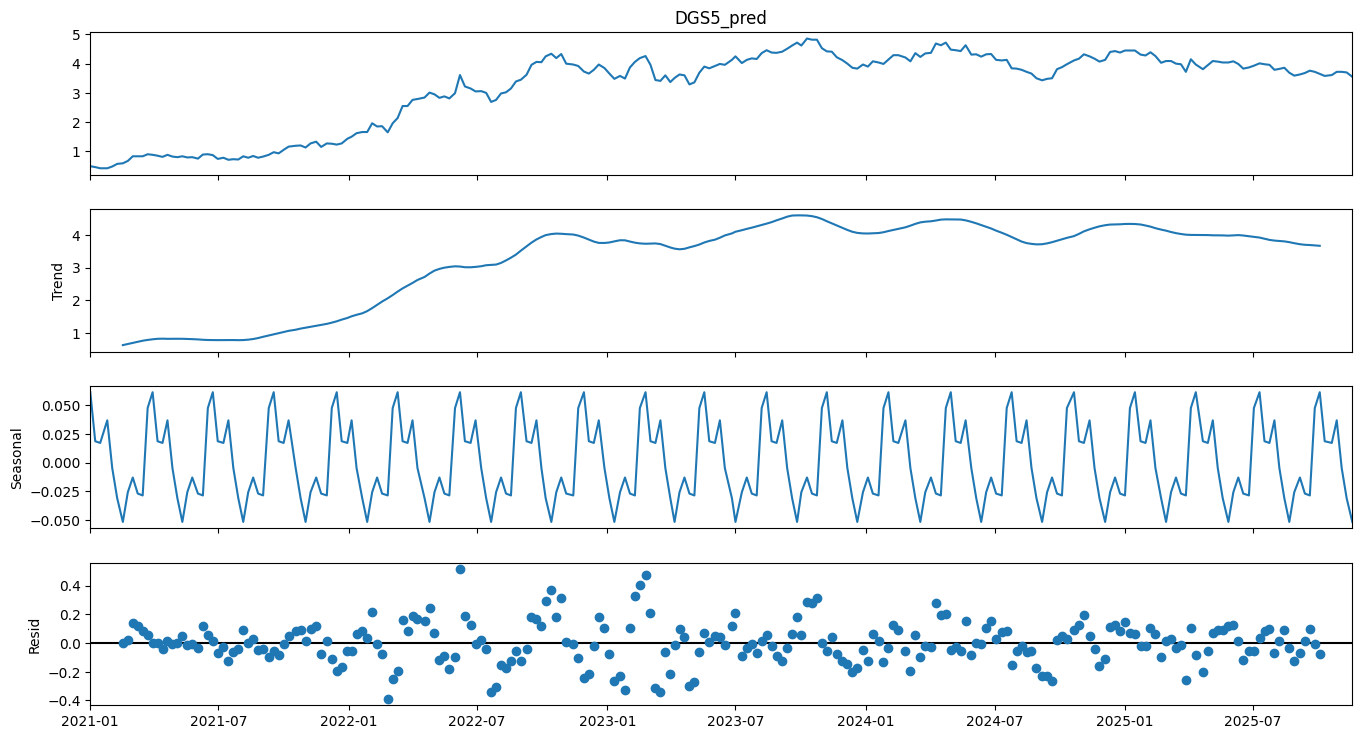

In [21]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y, model='additive', period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 30 Year

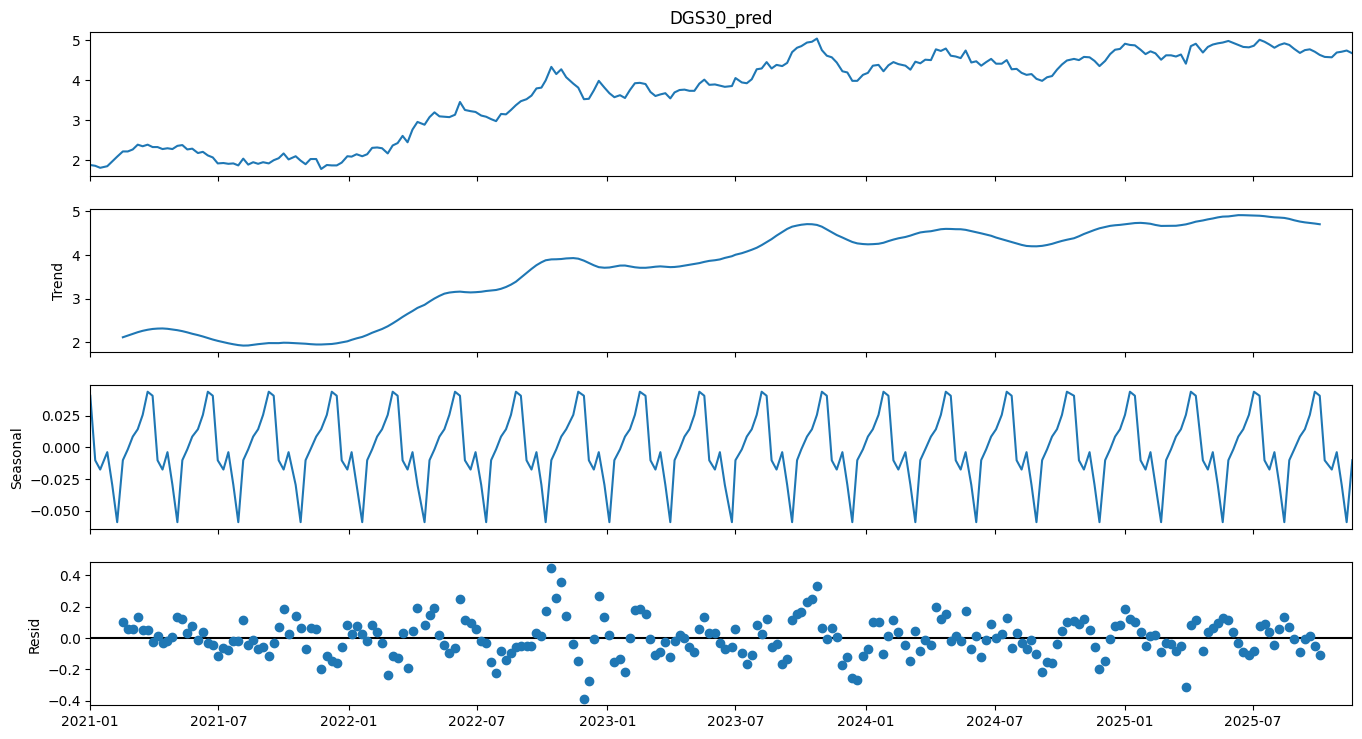

In [22]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y, model='additive', period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.


## Data Preparation and analysis


##  Univariate Feature Selection

In [23]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
     Specs         Score
0   DGS1MO  45582.400476
1   DGS3MO  23049.458728
2     DGS1   3218.605120
3     DGS2   1768.132762
6    DGS10   1450.223261
5     DGS7   1437.711628
4     DGS5   1358.806316
7    DGS30   1156.164652
8  GOV_PCT    289.448121
9  HOM_PCT    251.248017
--------------
DGS5_pred
      Specs         Score
4      DGS5  20437.512807
5      DGS7  11283.578316
3      DGS2   8008.462798
6     DGS10   4606.618288
2      DGS1   3418.665096
1    DGS3MO   1621.617237
7     DGS30   1555.499332
0    DGS1MO   1202.167325
10  FOR_PCT    272.830656
9   HOM_PCT    182.142825
--------------
DGS30_pred
     Specs         Score
7    DGS30  18677.629352
6    DGS10   6101.621893
5     DGS7   2785.191831
4     DGS5   1775.706711
0   DGS1MO   1125.903808
1   DGS3MO   1114.180784
3     DGS2   1071.897275
2     DGS1    967.230814
8  GOV_PCT    595.218542
9  HOM_PCT    498.219671
--------------


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.


#  Evaluate Algorithms and Models


# Train Test Split and evaluation metrics

In [24]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [25]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'


## Compare Models and Algorithms

In [26]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [28]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.01823098785311109 
Std CV Error: (0.0077044270903661805) 
Training Error:
0.014636396577748855 
Test Error:
0.030054860859458833
----------
LASSO: 
Average CV error: 0.36237738842803874 
Std CV Error: (0.07511107594790581) 
Training Error:
0.3544762271626301 
Test Error:
0.33553567394105904
----------
EN: 
Average CV error: 0.20461580385613948 
Std CV Error: (0.02893849031200405) 
Training Error:
0.20005826550094472 
Test Error:
0.196984878300018
----------
KNN: 
Average CV error: 0.023207371578947363 
Std CV Error: (0.010348488139200866) 
Training Error:
0.014346030456852793 
Test Error:
0.03103917333333333
----------
CART: 
Average CV error: 0.061881894736842115 
Std CV Error: (0.0740588524361645) 
Training Error:
0.0 
Test Error:
0.03466600000000001
----------
MLP: 
Average CV error: 0.34699055772030035 
Std CV Error: (0.1603703792430006) 
Training Error:
0.34237130306296343 
Test Error:
0.385400776742796
----------


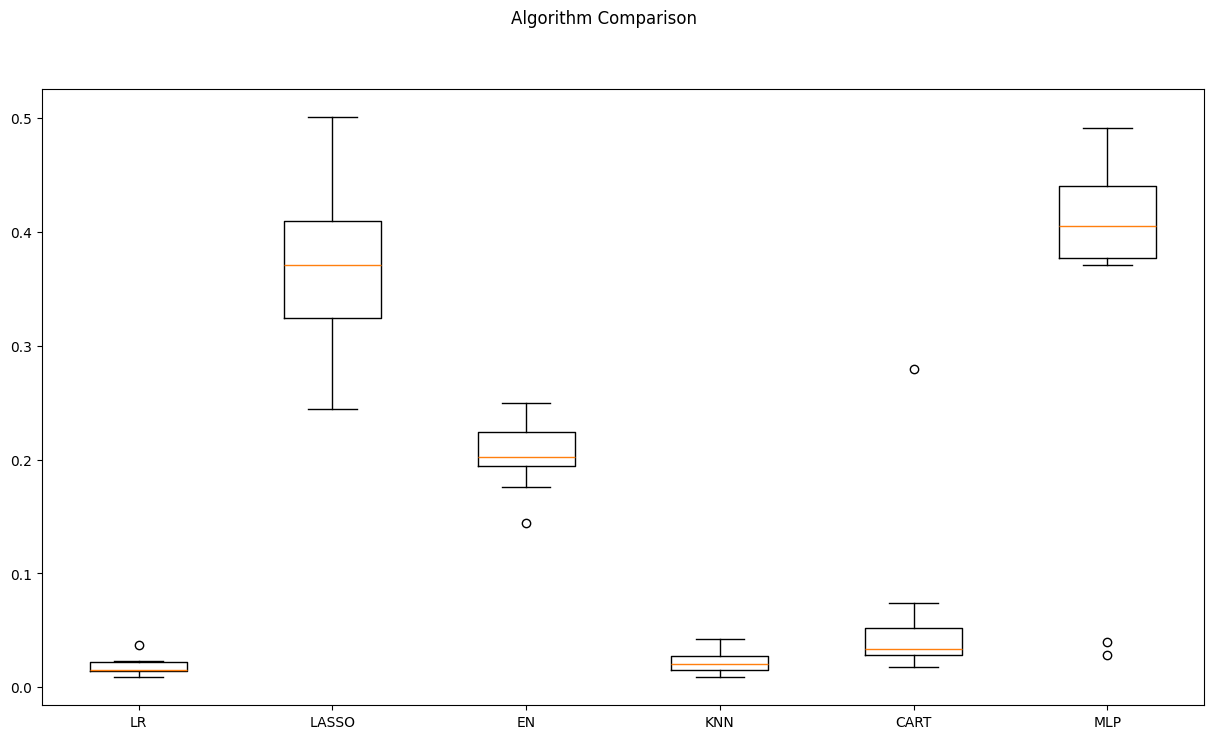

In [29]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

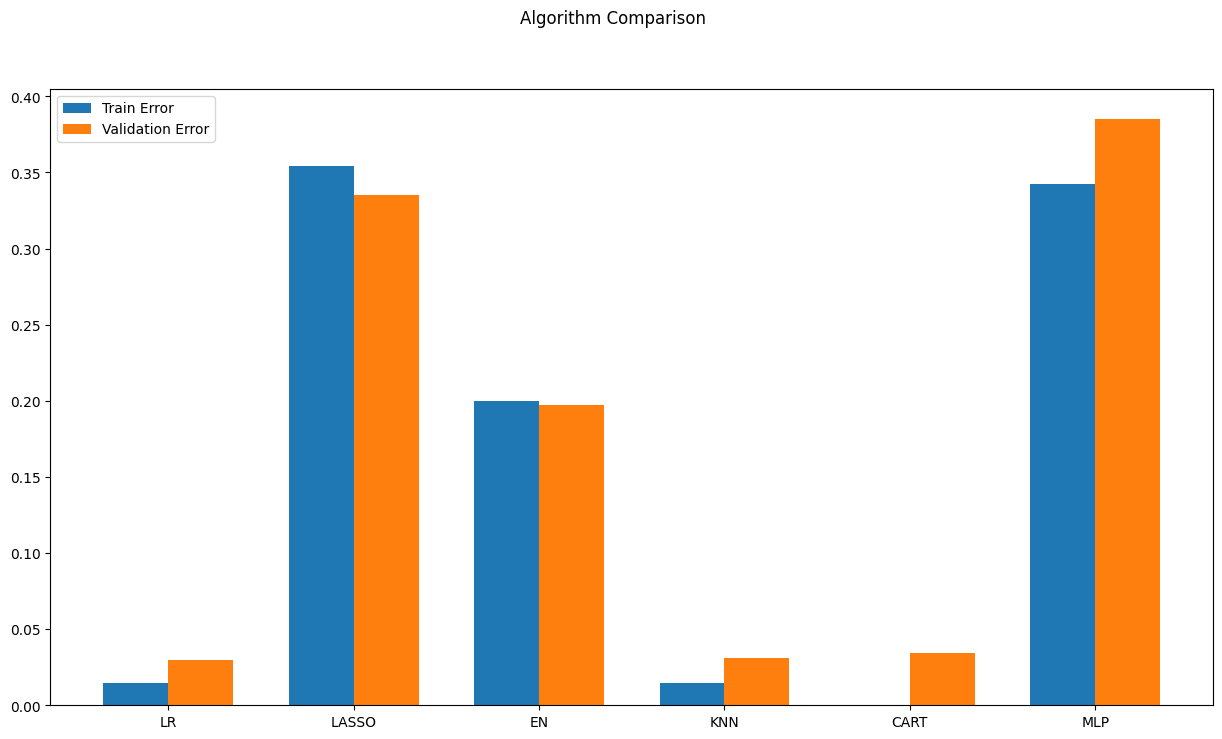

In [30]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()


#  Model Tuning and Grid Search

In [32]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.114873 using {'hidden_layer_sizes': (20, 30, 20)}
-0.148380 (0.066418) with: {'hidden_layer_sizes': (20,)}
-0.134200 (0.127363) with: {'hidden_layer_sizes': (50,)}
-0.128101 (0.093745) with: {'hidden_layer_sizes': (20, 20)}
-0.114873 (0.108832) with: {'hidden_layer_sizes': (20, 30, 20)}



#  Finalise the Model

In [33]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(20, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True



##  Results and comparison of Regression and MLP

In [34]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))


MSE Regression = 0.030055, MSE MLP = 0.038649
R2 Regression = 0.987528, R2 MLP = 0.981371


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set. 

### Predictions - 5 Year - MLP

In [35]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)


<Axes: xlabel='DATE'>

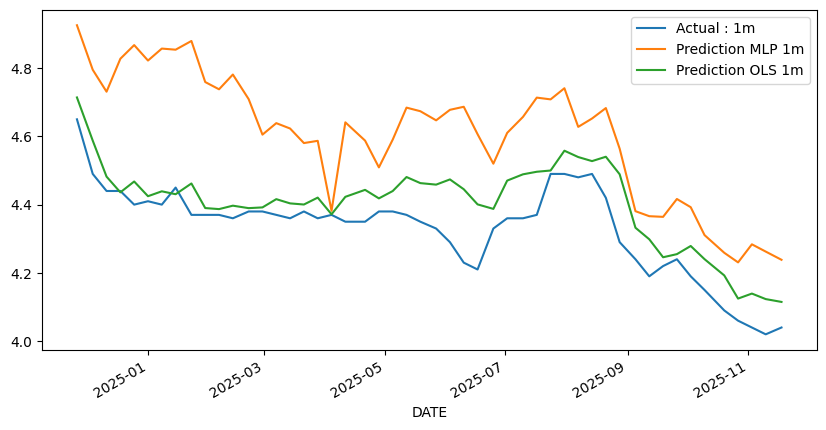

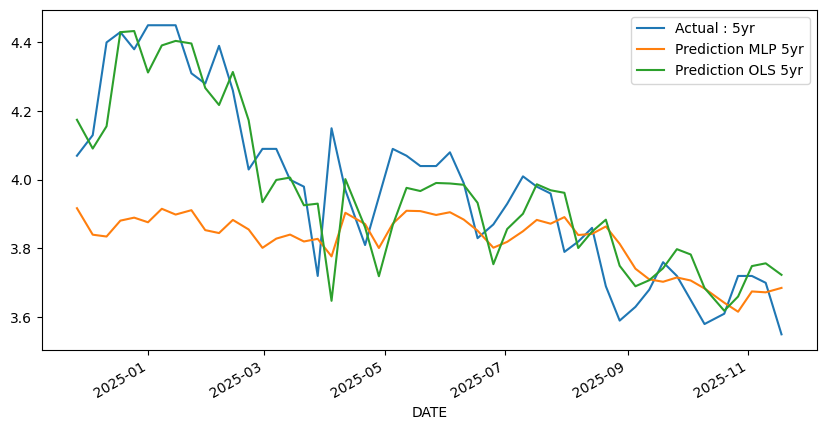

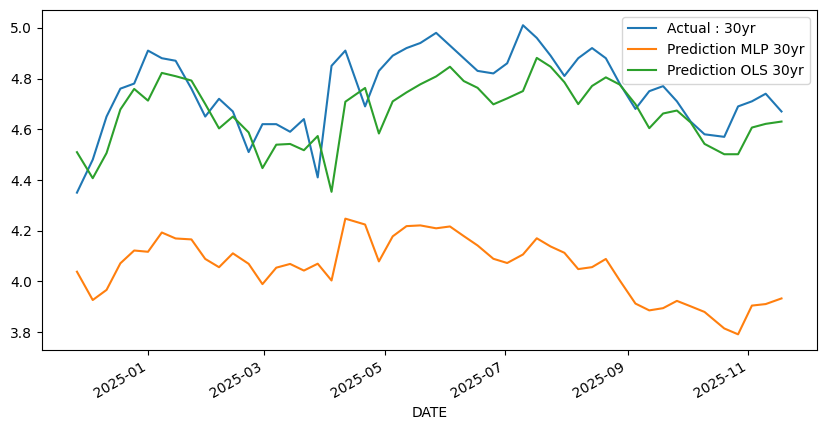

In [37]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))



Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneousl 